In [1]:
import pandas as pd
import numpy as np
import os
import json
import re

In [2]:
PROMPT_VERSIONS = 3
NUM_QUESTIONS = 1
LLM_VERSION = "41-mini"  # Change this to the desired LLM name
REPETITIONS = 6


QUESTIONS = [
    "Auf allen Deutschen Autobahnen soll es ein generelles Tempolimit geben",
    "Deutschland soll seine Verteidigungsausgaben erhöhen",
    "Bei Bundestagswahlen sollen auch Jugendliche ab 16 Jahren wählen dürfen.",
    "Die Förderung von Windenergie soll beendet werden.",
    "Die Möglichkeiten der Vermieterinnen und Vermieter, Wohnungsmieten zu erhöhen, sollen gesetzlich stärker begrenzt werden.",
]

In [3]:
# open dir ../configs
# Get the current working directory of the notebook
notebook_path = os.getcwd()

# Collect all answer DataFrames for each version and repetition
all_answers_versions = [[] for _ in range(PROMPT_VERSIONS * NUM_QUESTIONS)]
json_files_versions = [[] for _ in range(PROMPT_VERSIONS * NUM_QUESTIONS)]

for question_index in range(NUM_QUESTIONS):
    config_path = os.path.join(notebook_path, f"../config/question_{question_index}")
    print(config_path)
    # get name of all subdirectories in ../configs
    subdirs = [
        d
        for d in os.listdir(config_path)
        if os.path.isdir(os.path.join(config_path, d))
    ]
    print(subdirs)
    for subdir in subdirs:
        subdir_path = os.path.join(config_path, subdir)
        config_file = os.path.join(subdir_path, "config_0.json")
        try:
            with open(config_file, "r") as file:
                config_data = json.load(file)
            config_df = pd.json_normalize(config_data)
            party_1 = config_df["persons"][0][0]["party"]
            party_2 = config_df["persons"][0][1]["party"]
            name_1 = config_df["persons"][0][0]["name"]
            name_2 = config_df["persons"][0][1]["name"]
        except Exception as e:
            print(f"Error reading {config_file}: {e}")
            continue
        for v in range(PROMPT_VERSIONS):
            for repetition in range(REPETITIONS):
                json_file = os.path.join(
                    subdir_path, f"out_{LLM_VERSION}_v{v}_{repetition}.json"
                )
                if os.path.isfile(json_file):
                    json_files_versions[v].append(json_file)
                else:
                    continue
                try:
                    with open(json_file, "r") as file:
                        data = json.load(file)
                except Exception as e:
                    print(f"Error reading {json_file}: {e}")
                    continue
                columns = {}
                columns["question_index"] = question_index
                columns["party_1"] = party_1
                columns["party_2"] = party_2
                columns["repetition"] = repetition
                for q in data["survey_question"]:
                    name = q["chat_entry"]["entity"]["name"]
                    name = "agent_1" if name == name_1 else "agent_2"
                    iteration = q["iteration"]
                    col_name = f"{name}_T{iteration}"
                    columns[col_name] = q["chat_entry"]["answer"]
                answers_df = pd.DataFrame([columns])
                all_answers_versions[v + question_index * PROMPT_VERSIONS].append(
                    answers_df
                )

/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config/question_0
['CDU_CSU-AfD', 'Bündnis_90_Die_Grünen-AfD', 'Die_Linke-FDP', 'SPD-SPD', 'SPD-keine_Partei', 'Die_Linke-Die_Linke', 'FDP-FDP', 'AfD-AfD', 'CDU_CSU-keine_Partei', 'Bündnis_90_Die_Grünen-Bündnis_90_Die_Grünen', 'SPD-AfD', 'FDP-keine_Partei', 'Die_Linke-Bündnis_90_Die_Grünen', 'CDU_CSU-CDU_CSU', 'FDP-AfD', 'keine_Partei-keine_Partei', 'SPD-Bündnis_90_Die_Grünen', 'Bündnis_90_Die_Grünen-FDP', 'Bündnis_90_Die_Grünen-keine_Partei', 'Die_Linke-AfD', 'Die_Linke-CDU_CSU', 'Bündnis_90_Die_Grünen-CDU_CSU', 'Die_Linke-keine_Partei', 'AfD-keine_Partei', 'Die_Linke-SPD', 'SPD-CDU_CSU', 'SPD-FDP', 'FDP-CDU_CSU']


In [4]:
big_dfs: list[pd.DataFrame] = []
for v in range(PROMPT_VERSIONS * NUM_QUESTIONS):
    if all_answers_versions[v]:
        # print(f"all_answers_versions[{v}]: {all_answers_versions[v]}")
        big_df = pd.concat(all_answers_versions[v], ignore_index=True)
        big_dfs.append(big_df)

    else:
        print(f"No dataframes to concatenate for version {v}.")

# print(v)

In [5]:
# Helper function to process big_df into long format with agent_idx
def process_big_df(
    big_df: pd.DataFrame, version_label: str, question_index: int
) -> pd.DataFrame:
    t_row = ["party", "debate_with", "repetition"]
    for i in range(0, 11):
        t_row.append(f"T{i}")
    formatted_df = pd.DataFrame(columns=t_row)
    for row in big_df.iterrows():
        party_1 = row[1]["party_1"]
        party_2 = row[1]["party_2"]

        # agent_1 row
        agent_1_data = row[1].filter(like="agent_1")
        agent_1_data.index = agent_1_data.index.str.replace("agent_1_", "")
        agent_1_data = agent_1_data.rename(party_1)
        agent_1_data = agent_1_data.to_frame().T
        agent_1_data.insert(0, "debate_with", party_2)
        agent_1_data.insert(0, "party", party_1)
        agent_1_data.insert(0, "repetition", row[1]["repetition"])
        formatted_df = pd.concat([formatted_df, agent_1_data], ignore_index=True)
        # agent_2 row
        agent_2_data = row[1].filter(like="agent_2")
        agent_2_data.index = agent_2_data.index.str.replace("agent_2_", "")
        agent_2_data = agent_2_data.rename(party_2)
        agent_2_data = agent_2_data.to_frame().T
        agent_2_data.insert(0, "debate_with", party_1)
        agent_2_data.insert(0, "party", party_2)
        agent_2_data.insert(0, "repetition", row[1]["repetition"])
        formatted_df = pd.concat([formatted_df, agent_2_data], ignore_index=True)
    formatted_df = formatted_df.reset_index(drop=True)
    for col in formatted_df.columns:
        if col.startswith("T"):

            def extract_number(text):
                if pd.isna(text):
                    return None
                if isinstance(text, (int, float)):
                    return text
                text = str(text)
                numbers = re.findall(r"\d+", text)
                if numbers:
                    return int(numbers[0])
                else:
                    return None

            formatted_df[col] = formatted_df[col].apply(extract_number)

    formatted_df["version"] = version_label
    formatted_df["question_index"] = question_index

    return formatted_df


formatted_df_all: list[pd.DataFrame] | pd.DataFrame = []
for question_index in range(NUM_QUESTIONS):
    for v in range(PROMPT_VERSIONS):
        version_label = f"out_{v}"
        # Only process if big_dfs has data for this version
        if v < len(big_dfs):
            formatted_df_all.append(
                process_big_df(
                    big_dfs[v + question_index * PROMPT_VERSIONS],
                    version_label,
                    question_index,
                )
            )
        else:
            print(f"Skipping version {version_label} due to missing data.")


formatted_df: pd.DataFrame = pd.concat(formatted_df_all, ignore_index=True)

In [6]:
formatted_df_non_abs = formatted_df.copy()
# remove T1, T2, T3, T5, T6, T7, T9, T10, T11, T13,

remove_columns = [
    "T1",
    "T2",
    "T3",
    "T5",
    "T6",
    "T7",
    "T9",
    "T10",
    "T11",
    "T13",
]
formatted_df_non_abs = formatted_df_non_abs.drop(
    columns=remove_columns, errors="ignore"
)


print(formatted_df_non_abs.iloc[0, :])
display(formatted_df_non_abs)

party_df_non_abs = formatted_df_non_abs.melt(
    id_vars=["party", "debate_with", "version", "question_index", "repetition"],
    var_name="iteration",
    value_name="answer",
)
party_df_non_abs = party_df_non_abs.dropna(subset=["answer"]).reset_index(drop=True)
display(party_df_non_abs)

party             CDU/CSU
debate_with           AfD
repetition              0
T0                      4
T4                      5
T8                      5
T12                     5
T16                     5
T20                     5
version             out_0
question_index          0
Name: 0, dtype: object


,party,debate_with,repetition,T0,T4,T8,T12,T16,T20,version,question_index
0,CDU/CSU,AfD,0,4,5,5,5,5,5,out_0,0
1,AfD,CDU/CSU,0,3,3,3,3,4,3,out_0,0
2,CDU/CSU,AfD,1,4,5,5,5,5,5,out_0,0
3,AfD,CDU/CSU,1,3,3,3,3,3,3,out_0,0
4,CDU/CSU,AfD,2,4,5,5,5,5,5,out_0,0
...,...,...,...,...,...,...,...,...,...,...,...
1003,CDU/CSU,FDP,3,4,4,5,5,5,4,out_2,0
1004,FDP,CDU/CSU,4,6,6,5,5,5,5,out_2,0
1005,CDU/CSU,FDP,4,4,4,4,4,5,4,out_2,0
1006,FDP,CDU/CSU,5,6,5,6,6,6,6,out_2,0


,party,debate_with,version,question_index,repetition,iteration,answer
0,CDU/CSU,AfD,out_0,0,0,T0,4
1,AfD,CDU/CSU,out_0,0,0,T0,3
2,CDU/CSU,AfD,out_0,0,1,T0,4
3,AfD,CDU/CSU,out_0,0,1,T0,3
4,CDU/CSU,AfD,out_0,0,2,T0,4
...,...,...,...,...,...,...,...
6043,CDU/CSU,FDP,out_2,0,3,T20,4
6044,FDP,CDU/CSU,out_2,0,4,T20,5
6045,CDU/CSU,FDP,out_2,0,4,T20,4
6046,FDP,CDU/CSU,out_2,0,5,T20,6


6048
Index(['party', 'debate_with', 'version', 'question_index', 'repetition',
       'iteration', 'answer'],
      dtype='object')


,party,debate_with,version,question_index,repetition,iteration,answer
0,CDU/CSU,AfD,out_0,0,0,T0,4
1,AfD,CDU/CSU,out_0,0,0,T0,3
2,CDU/CSU,AfD,out_0,0,1,T0,4
3,AfD,CDU/CSU,out_0,0,1,T0,3
4,CDU/CSU,AfD,out_0,0,2,T0,4
...,...,...,...,...,...,...,...
6043,CDU/CSU,FDP,out_2,0,3,T20,4
6044,FDP,CDU/CSU,out_2,0,4,T20,5
6045,CDU/CSU,FDP,out_2,0,4,T20,4
6046,FDP,CDU/CSU,out_2,0,5,T20,6


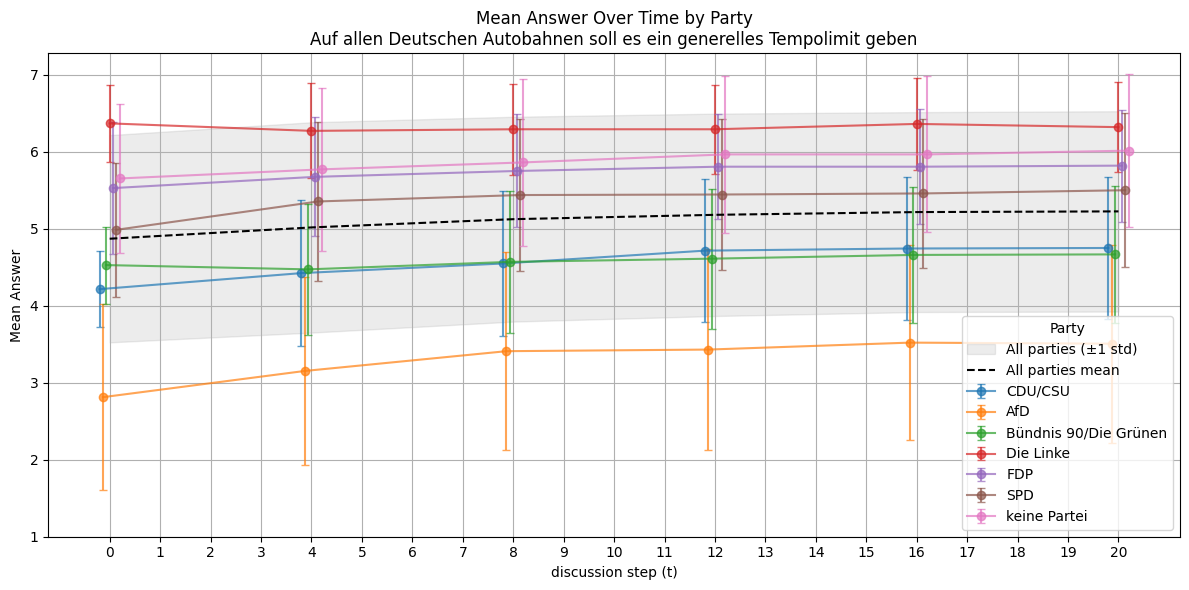

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plot_df = party_df_non_abs.copy()


print(len(plot_df))
print(plot_df.columns)

display(plot_df)
plot_df["iteration"] = plot_df["iteration"].str.replace("T", "").astype(int)
plot_df = plot_df[(plot_df["answer"] <= 7) & (plot_df["answer"] >= 1)]
plot_df["answer"] = pd.to_numeric(plot_df["answer"], errors="coerce")

parties = list(plot_df["party"].unique())
offsets = np.linspace(-0.2, 0.2, len(parties))  # For party errorbars

for question in plot_df["question_index"].unique():
    plt.figure(figsize=(12, 6))
    # Plot per-party errorbars, slightly offset
    for i, party in enumerate(parties):
        party_data = plot_df[
            (plot_df["party"] == party) & (plot_df["question_index"] == question)
        ]
        means = party_data.groupby("iteration")["answer"].mean()
        stds = party_data.groupby("iteration")["answer"].std()
        x = means.index + offsets[i]
        plt.errorbar(
            x,
            means.values,
            yerr=stds.values,
            marker="o",
            label=f"{party}",
            capsize=3,
            alpha=0.7,
        )
    # Plot overall mean and std as a field (no offset)
    all_data = plot_df[plot_df["question_index"] == question]
    all_means = all_data.groupby("iteration")["answer"].mean()
    all_stds = all_data.groupby("iteration")["answer"].std()
    plt.fill_between(
        all_means.index,
        all_means - all_stds,
        all_means + all_stds,
        color="gray",
        alpha=0.15,
        label="All parties (±1 std)",
    )
    plt.plot(
        all_means.index,
        all_means.values,
        color="black",
        linestyle="--",
        label="All parties mean",
    )
    plt.title(f"Mean Answer Over Time by Party\n{QUESTIONS[question]}")
    plt.xticks(range(0, 21))
    plt.yticks(range(1, 8))
    plt.xlabel("discussion step (t)")
    plt.ylabel("Mean Answer")
    plt.legend(title="Party")
    plt.grid()
    plt.tight_layout()
    plt.show()

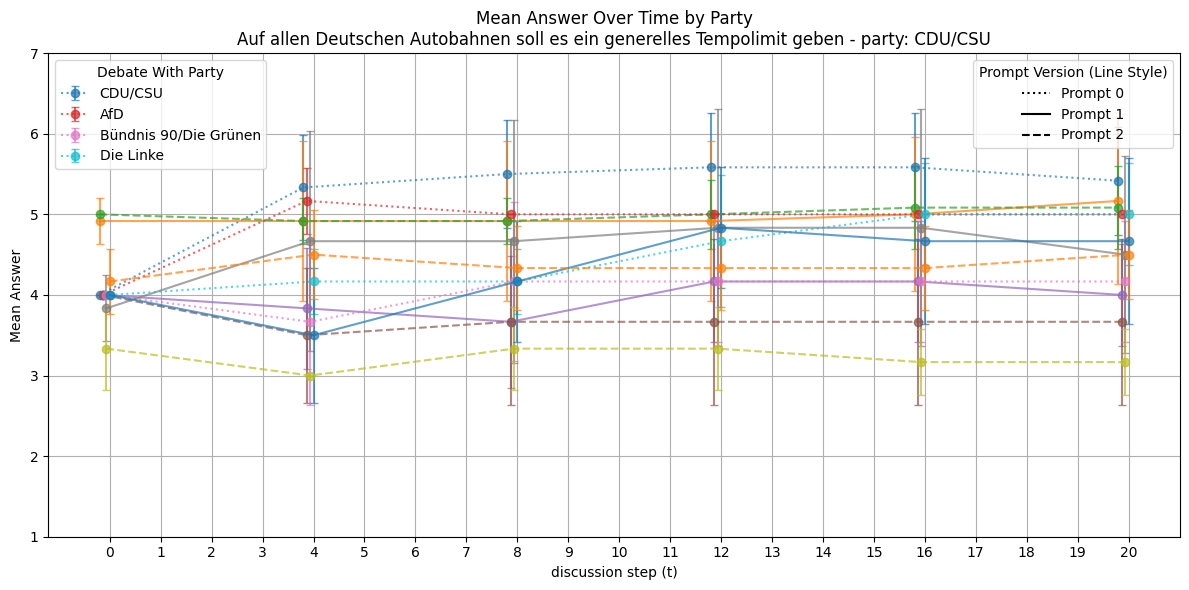

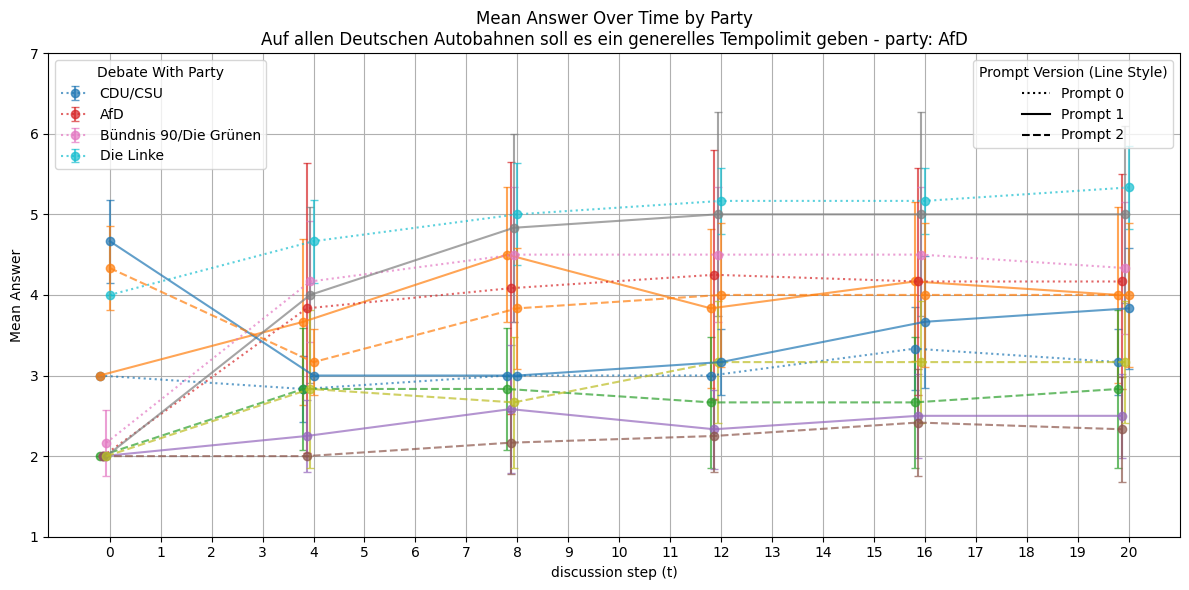

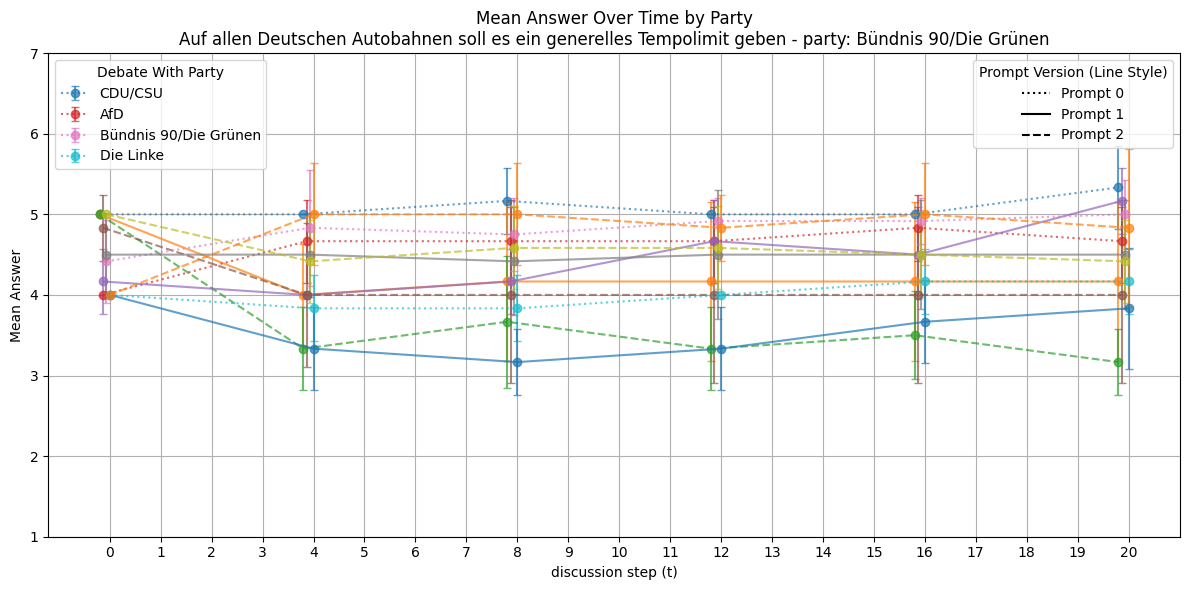

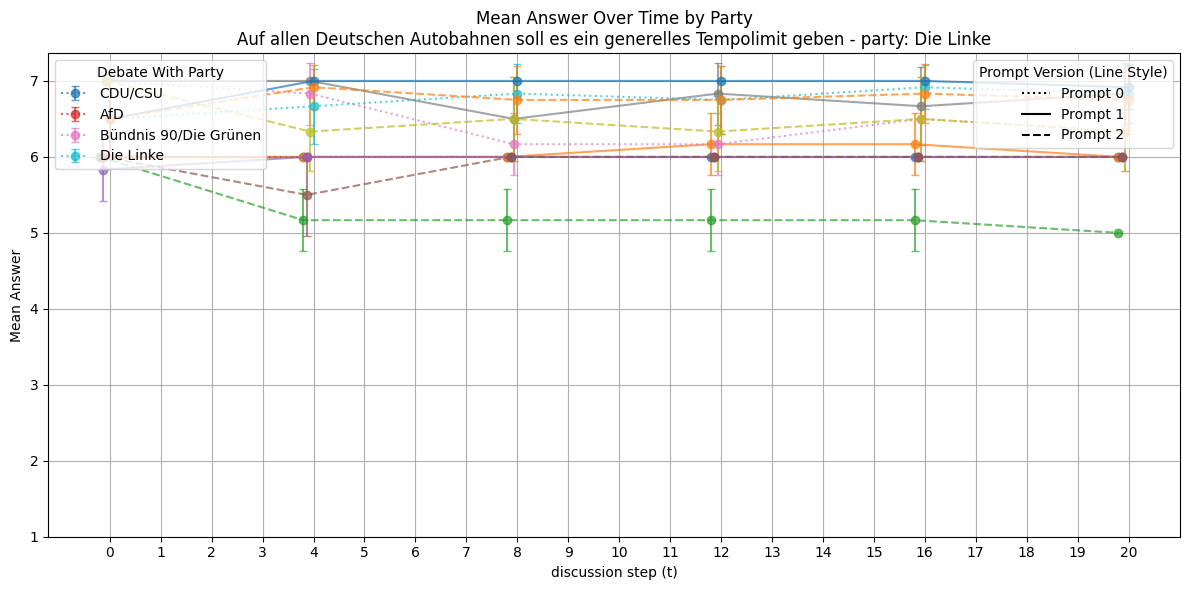

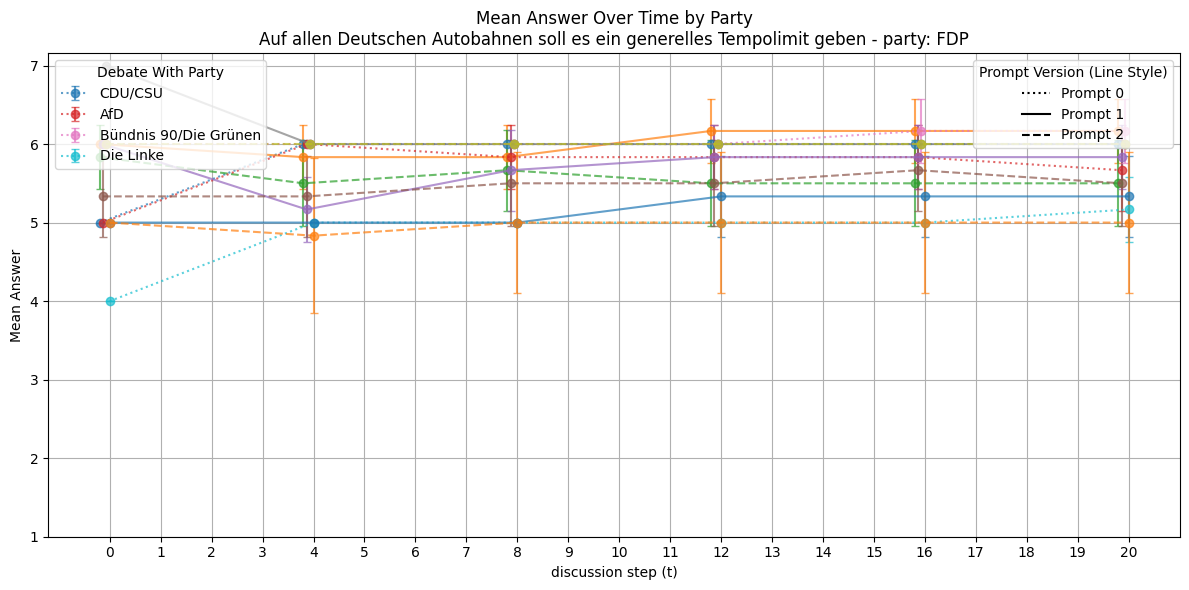

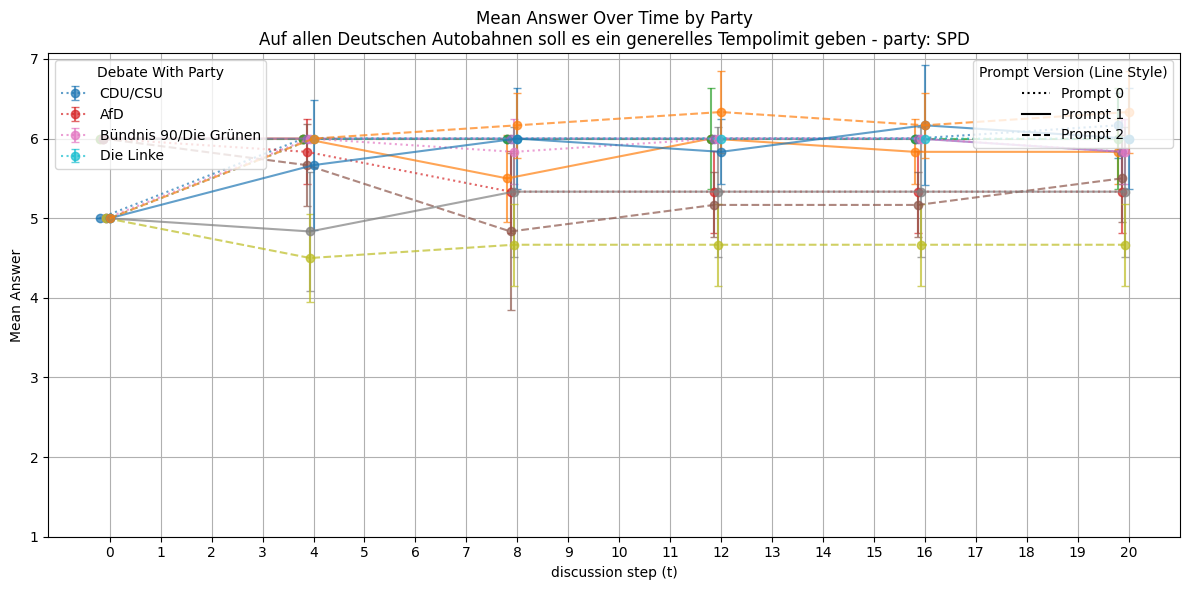

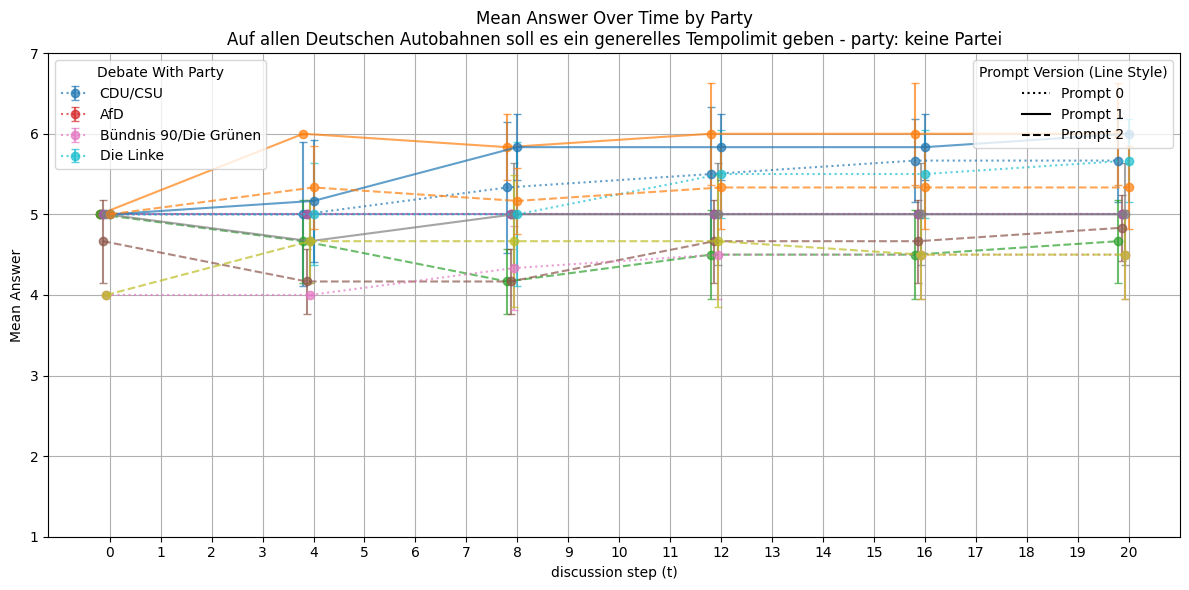

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plot_df = party_df_non_abs.copy()
plot_df["iteration"] = plot_df["iteration"].str.replace("T", "").astype(int)
plot_df = plot_df[(plot_df["answer"] <= 7) & (plot_df["answer"] >= 1)]
plot_df["answer"] = pd.to_numeric(plot_df["answer"], errors="coerce")

parties = list(plot_df["party"].unique())
offsets = np.linspace(-0.2, 0.2, len(parties))  # For party errorbars
plot_df[plot_df["question_index"] == 0]  # Filter for question index 0


q_i = 0

parties = ['CDU/CSU', 'AfD', 'Bündnis 90/Die Grünen', 'Die Linke']



linestyles = {0: ':', 1: '-', 2: '--'}
prompt_labels = {0: 'Prompt 0', 1: 'Prompt 1', 2: 'Prompt 2'}

for party in plot_df["party"].unique():
    plt.figure(figsize=(12, 6))
    handles = []
    labels = []
    for i, debate_with_party in enumerate(parties):
        for prompt_v in [0, 1, 2]:
            party_data = plot_df[
                (plot_df["party"] == party)
                & (plot_df["debate_with"] == debate_with_party)
                & (plot_df["question_index"] == q_i)
                & (plot_df["version"] == f"out_{prompt_v}")
            ]
            if party_data.empty:
                continue
            means = party_data.groupby("iteration")["answer"].mean()
            stds = party_data.groupby("iteration")["answer"].std()
            x = means.index + offsets[i]
            linestyle = linestyles[prompt_v]
            # Only add party label once
            label = debate_with_party if prompt_v == 0 else None
            h = plt.errorbar(
                x,
                means.values,
                yerr=stds.values,
                marker="o",
                label=label,
                capsize=3,
                alpha=0.7,
                linestyle=linestyle,
            )
            if prompt_v == 0:
                handles.append(h)
                labels.append(debate_with_party)
    # Add custom legend for linestyles (prompt versions)
    from matplotlib.lines import Line2D
    linestyle_handles = [
        Line2D([0], [0], color='black', linestyle=ls, label=prompt_labels[v])
        for v, ls in linestyles.items()
    ]
    # First legend: parties
    leg1 = plt.legend(handles=handles, labels=labels, title="Debate With Party", loc='upper left')
    plt.gca().add_artist(leg1)
    # Second legend: prompt version (linestyle)
    plt.legend(handles=linestyle_handles, title="Prompt Version (Line Style)", loc='upper right')

    plt.title(f"Mean Answer Over Time by Party\n{QUESTIONS[q_i]} - party: {party}")
    plt.xticks(range(0, 21))
    plt.yticks(range(1, 8))
    plt.xlabel("discussion step (t)")
    plt.ylabel("Mean Answer")
    plt.grid()
    plt.tight_layout()
    plt.show()

## calculating in group vs outgroups 

ANOVA for question 0: Auf allen Deutschen Autobahnen soll es ein generelles Tempolimit geben
                         sum_sq     df           F         PR(>F)
C(version)            43.728175    2.0   28.560662   8.789200e-13
C(party)             766.534392    6.0  166.885001  4.389516e-146
C(debate_with)        63.659392    6.0   13.859519   3.604567e-15
C(version):C(party)   19.202381   12.0    2.090310   1.533215e-02
Residual             750.986442  981.0         NaN            NaN


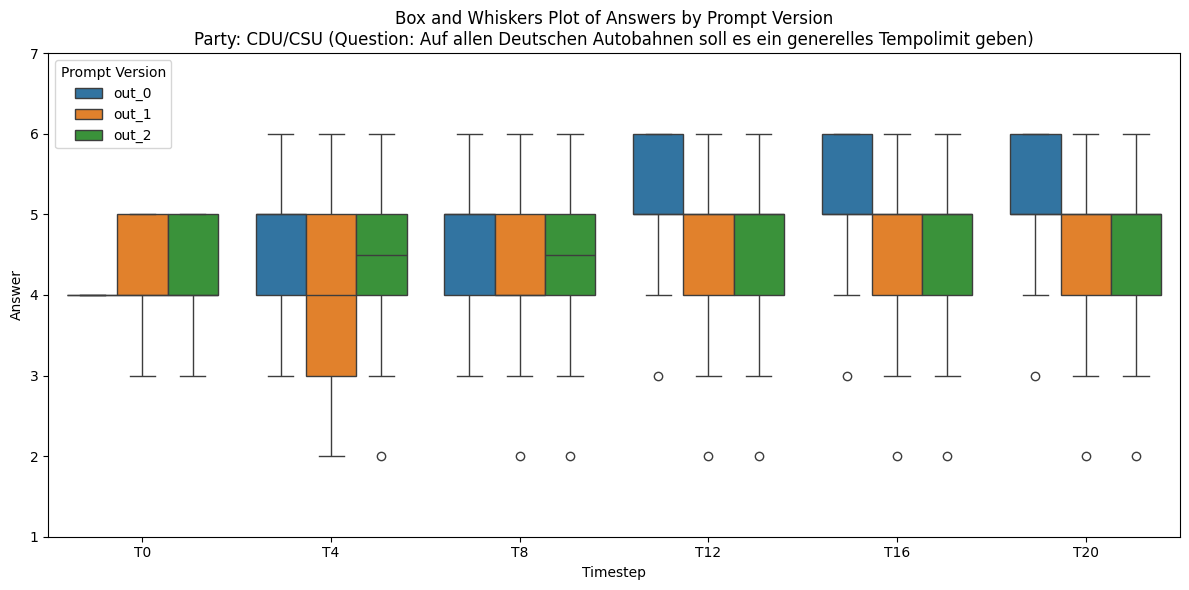

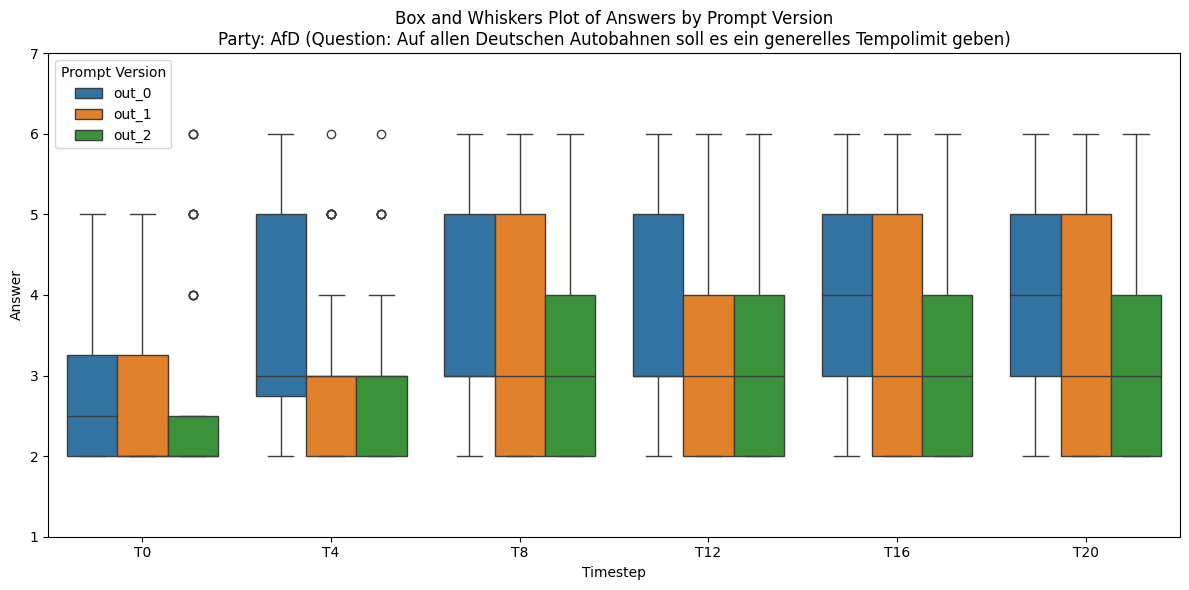

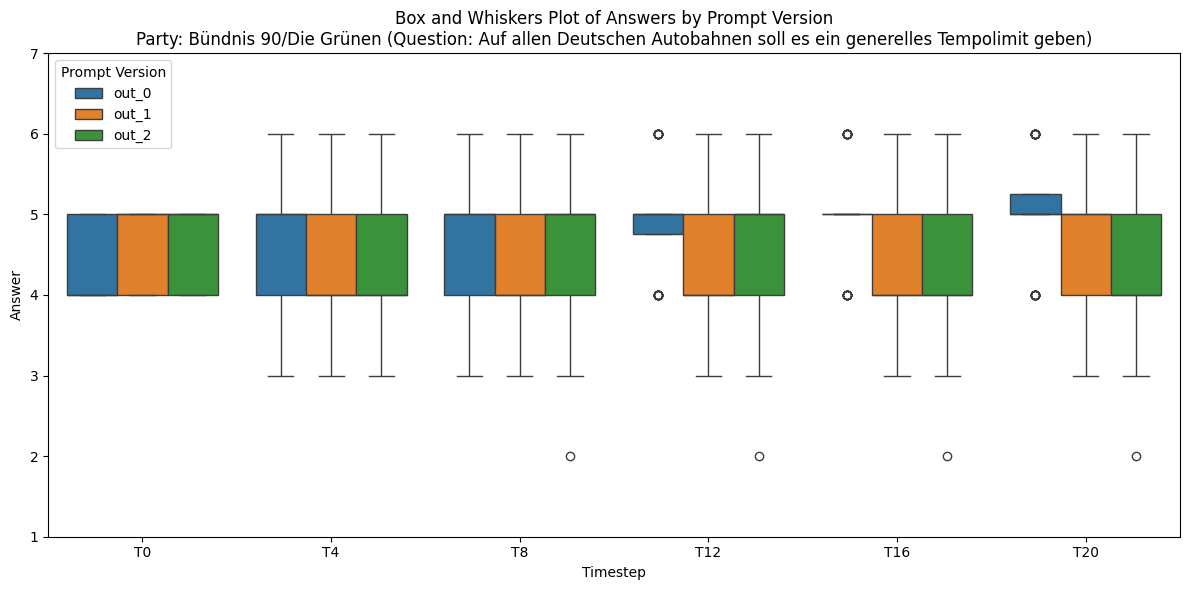

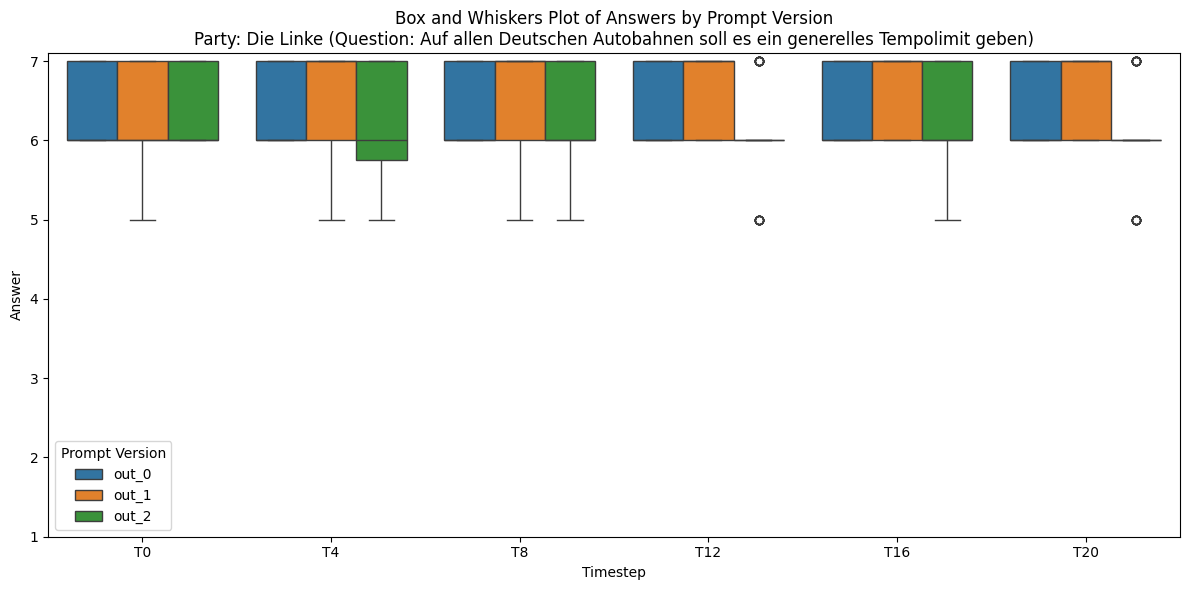

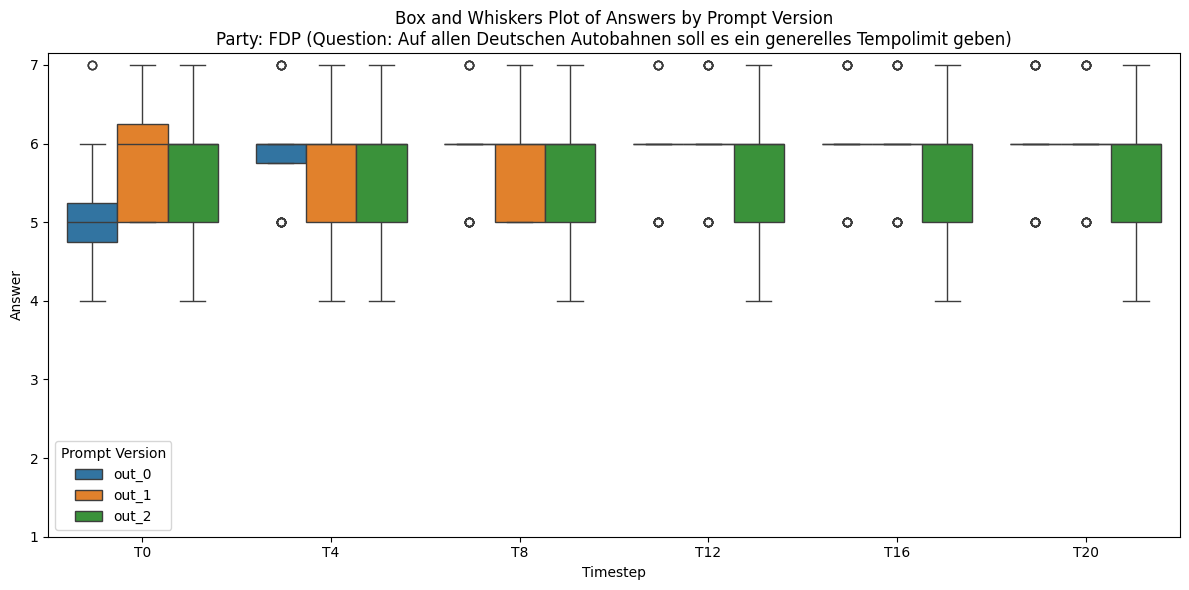

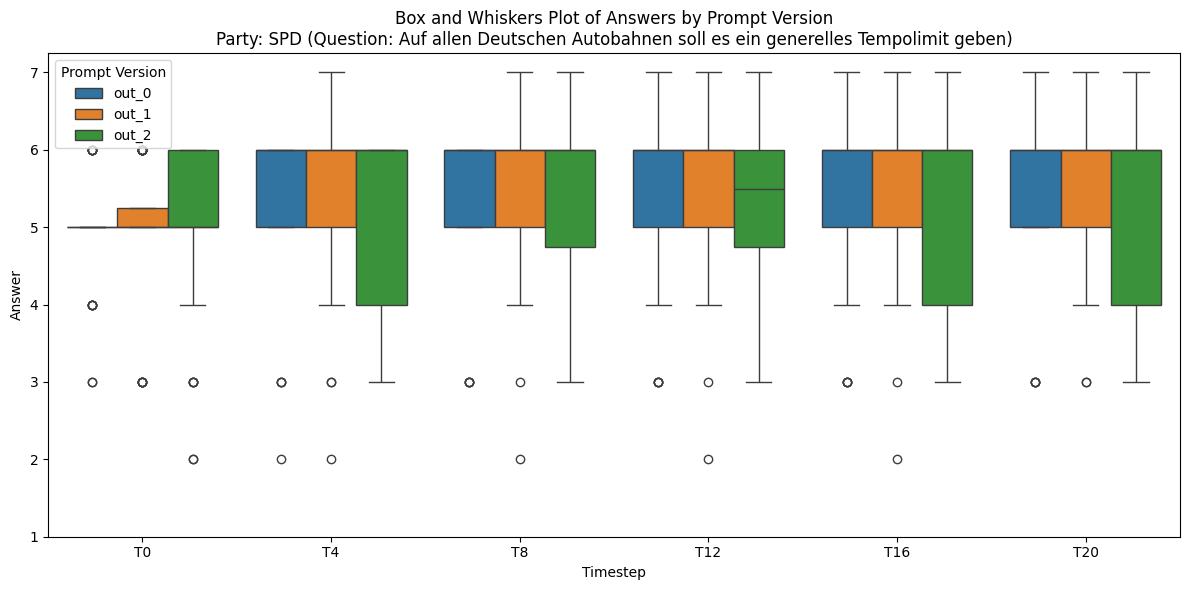

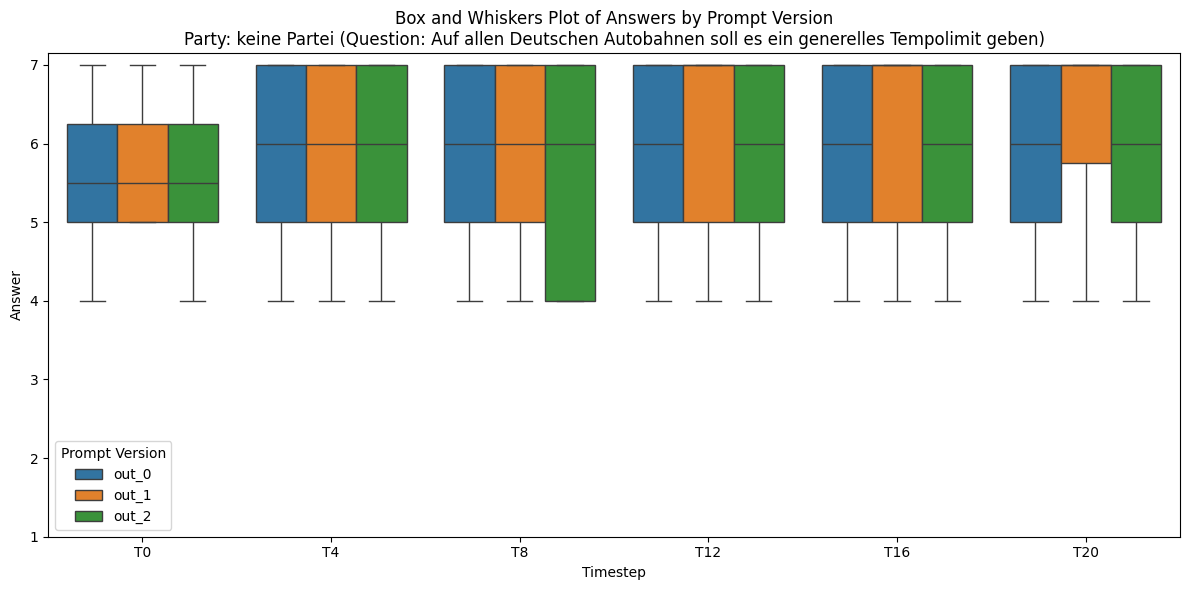

In [9]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Perform ANOVA for each question
for question_index in range(NUM_QUESTIONS):
    print(f"ANOVA for question {question_index}: {QUESTIONS[question_index]}")

    question_data = formatted_df_non_abs[
        formatted_df_non_abs["question_index"] == question_index
    ]

    if question_data.empty:
        print("No data available for this question.")
        continue

    # Fit OLS model
    model = ols(
        "T20 ~ C(version)*C(party) + C(debate_with)",
        data=question_data
    ).fit()

    # Get ANOVA table
    anova_table = anova_lm(model, typ=2)  # typ=2 is common for factorial designs
    print(anova_table)


# create a box and whiskers plot for the answers at T20
import seaborn as sns

# Prepare data in long format for the selected party and time steps
timesteps = ["T0", "T4", "T8", "T12", "T16", "T20"]
for party in formatted_df_non_abs["party"].unique():
    party_data = formatted_df_non_abs[formatted_df_non_abs["party"] == party]
    # Melt to long format for the selected timesteps
    long_df = party_data.melt(
        id_vars=["party", "version", "question_index", "repetition", "debate_with"],
        value_vars=timesteps,
        var_name="timestep",
        value_name="answer"
    )

    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x="timestep",
        y="answer",
        hue="version",
        data=long_df[long_df["question_index"] == 0],
        dodge=True,
    )
    plt.title(f"Box and Whiskers Plot of Answers by Prompt Version\nParty: {party} (Question: {QUESTIONS[0]})")
    plt.xlabel("Timestep")
    plt.ylabel("Answer")
    plt.yticks(range(1, 8))
    plt.legend(title="Prompt Version")
    plt.tight_layout()
    plt.show()

In [10]:
party_df_non_abs

,party,debate_with,version,question_index,repetition,iteration,answer
0,CDU/CSU,AfD,out_0,0,0,T0,4
1,AfD,CDU/CSU,out_0,0,0,T0,3
2,CDU/CSU,AfD,out_0,0,1,T0,4
3,AfD,CDU/CSU,out_0,0,1,T0,3
4,CDU/CSU,AfD,out_0,0,2,T0,4
...,...,...,...,...,...,...,...
6043,CDU/CSU,FDP,out_2,0,3,T20,4
6044,FDP,CDU/CSU,out_2,0,4,T20,5
6045,CDU/CSU,FDP,out_2,0,4,T20,4
6046,FDP,CDU/CSU,out_2,0,5,T20,6


In [22]:
# LMM - Linearly Mixed Model
# Model: answer ~ iteration + party + version, random intercept for agent_idx within party

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Prepare the main dataframe for LMM once, outside the loop
lmm_data = party_df_non_abs.copy()
lmm_data = lmm_data.dropna(subset=["answer"]).reset_index(drop=True)
lmm_data["answer"] = pd.to_numeric(lmm_data["answer"], errors="coerce")
lmm_data["time"] = lmm_data["iteration"].str.extract(r"T(\d+)").astype(float)
# map from 0,4,8,12,16,20 to 0,1,2,3,4,5
lmm_data["time"] = lmm_data["time"].apply(
    lambda x: x / 4 if pd.notna(x) else np.nan
)
lmm_data["time"] = pd.to_numeric(lmm_data["time"], errors="coerce")
lmm_data["question_index"] = lmm_data["question_index"].astype("category")
lmm_data["party"] = lmm_data["party"].astype("category")
lmm_data["debate_with"] = lmm_data["debate_with"].astype("category")
lmm_data = lmm_data.reset_index(drop=True)






for prompt_version in ['out_0', 'out_1' ,'out_2']:
    print(f"Processing version: {prompt_version}")

    # Filter the data for the current version
    version_data = lmm_data[lmm_data["version"] == prompt_version].copy()

    # Define groups for this subset of data
    groups = (
        version_data["party"].astype(str)
        + "_"
        + version_data["debate_with"].astype(str)
        + "_"
        + version_data["repetition"].astype(str)
    )

    md = smf.mixedlm(
        "answer ~ C(party) * time",
        version_data,
        groups=groups,
    )
    mdf = md.fit()
    print(mdf.summary())

Processing version: out_0
                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         answer    
No. Observations:          2016            Method:                     REML      
No. Groups:                294             Scale:                      0.2827    
Min. group size:           6               Log-Likelihood:             -1962.7662
Max. group size:           12              Converged:                  Yes       
Mean group size:           6.9                                                   
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               3.232    0.115 28.115 0.000  3.007  3.457
C(party)[T.Bündnis 90/Die Grünen]       1.324    0.163  8.146 0.000  1.006  1.643
C(party)[T.C

In [16]:
from scipy.stats import chi2


# Model A: Includes 'version' and all its interactions
full_model = smf.mixedlm(
    "answer ~ time * version * question_index * party",
    lmm_data,
    groups=groups,
).fit(reml=False)
print("Full Model Summary:")
print(full_model.summary())


# Model B: Excludes 'version' and all its interactions
reduced_model = smf.mixedlm(
    "answer ~ time * question_index * party",
    lmm_data,
    groups=groups,
).fit(reml=False)
print("Reduced Model Summary:")
print(reduced_model.summary())
#

print("full_model:")
print(full_model.llf)
print(full_model.params.shape[0])


print("reduced_model:")
print(reduced_model.llf)
print(reduced_model.params.shape[0])


lr_stat = 2 * (full_model.llf - reduced_model.llf)
df_diff = full_model.params.shape[0] - reduced_model.params.shape[0]
p_value = chi2.sf(lr_stat, df_diff)

print("\nLikelihood-Ratio Test Results:")
print(f"LR Statistic: {lr_stat:.4f}")
print(f"Degrees of Freedom: {df_diff}")
print(f"P-value: {p_value:.4f}")

ValueError: operands could not be broadcast together with shapes (6048,1) (2016,1) 

In [ ]:
def backward_elimination(data, groups):
    """
    Performs backward elimination for a mixed-effects model.
    """
    # --- Define model formulas ---
    # Start with the most complex model
    current_formula = "answer ~ time * version * question_index + party"

    print(f"Starting backward elimination with full model:\n{current_formula}\n")

    # --- Test 1: Three-way interaction (time:version:question_index) ---
    print("--- Testing 3-way interaction: time:version:question_index ---")

    full_model = smf.mixedlm(current_formula, data, groups=groups).fit(reml=False)

    # Model without the 3-way interaction
    reduced_formula_1 = (
        "answer ~ time*version + time*question_index + version*question_index + party"
    )
    reduced_model_1 = smf.mixedlm(reduced_formula_1, data, groups=groups).fit(
        reml=False
    )

    lr_stat = 2 * (full_model.llf - reduced_model_1.llf)
    df_diff = full_model.params.shape[0] - reduced_model_1.params.shape[0]
    p_value = chi2.sf(lr_stat, df_diff)

    print(f"LRT P-value for time:version:question_index = {p_value:.4f}")

    if p_value < 0.05:
        print("Result: The 3-way interaction is significant. Stopping elimination.")
        print(f"\nFinal recommended model:\n{current_formula}")
        return current_formula
    else:
        print("Result: The 3-way interaction is NOT significant. Removing it.")
        current_formula = reduced_formula_1

    # --- Test 2: Two-way interactions ---
    print("\n--- Testing 2-way interactions ---")

    # Terms to test, in order of complexity
    two_way_terms = {
        "time:version": "answer ~ time*question_index + version*question_index + party + time + version",
        "time:question_index": "answer ~ time*version + version*question_index + party + time + question_index",
        "version:question_index": "answer ~ time*version + time*question_index + party + version + question_index",
    }

    for term, reduced_formula in two_way_terms.items():
        print(f"Testing term: {term}")

        full_model = smf.mixedlm(current_formula, data, groups=groups).fit(reml=False)
        reduced_model = smf.mixedlm(reduced_formula, data, groups=groups).fit(
            reml=False
        )

        lr_stat = 2 * (full_model.llf - reduced_model.llf)
        df_diff = full_model.params.shape[0] - reduced_model.params.shape[0]
        p_value = chi2.sf(lr_stat, df_diff)

        print(f"LRT P-value for {term} = {p_value:.4f}")

        if p_value >= 0.05:
            print(f"Result: {term} is NOT significant. Removing it.")
            current_formula = reduced_formula
        else:
            print(f"Result: {term} is significant. Keeping it.")

    print(f"\nFinal recommended model after testing interactions:\n{current_formula}")

    # You could extend this logic to test main effects if all interactions are removed.

    return current_formula


# --- Run the analysis ---
# Ensure lmm_data and groups are defined from the previous cell
final_model_formula = backward_elimination(lmm_data, groups)

print("\n--- Fitting the final recommended model ---")
final_model = smf.mixedlm(final_model_formula, lmm_data, groups=groups).fit()
print(final_model.summary())

Starting backward elimination with full model:
answer ~ time * version * question_index + party

--- Testing 3-way interaction: time:version:question_index ---
LRT P-value for time:version:question_index = nan
Result: The 3-way interaction is NOT significant. Removing it.

--- Testing 2-way interactions ---
Testing term: time:version
LRT P-value for time:version:question_index = nan
Result: The 3-way interaction is NOT significant. Removing it.

--- Testing 2-way interactions ---
Testing term: time:version
LRT P-value for time:version = 0.0000
Result: time:version is significant. Keeping it.
Testing term: time:question_index
LRT P-value for time:version = 0.0000
Result: time:version is significant. Keeping it.
Testing term: time:question_index
LRT P-value for time:question_index = nan
Result: time:question_index is significant. Keeping it.
Testing term: version:question_index
LRT P-value for time:question_index = nan
Result: time:question_index is significant. Keeping it.
Testing term:

In [ ]:
full_model = smf.mixedlm(
    "answer ~ time + party*question_index * time+ time:version:question_index",
    lmm_data,
    groups=groups,
).fit(reml=False)

print("Full Model Summary:")
print(full_model.summary())
reduced_model = smf.mixedlm(
    "answer ~ time + party*question_index * time+ time:question_index",
    lmm_data,
    groups=groups,
).fit(reml=False)
print("Reduced Model Summary:")
print(reduced_model.summary())


chi2_stat = 2 * (full_model.llf - reduced_model.llf)
df_diff = full_model.params.shape[0] - reduced_model.params.shape[0]
p_value = chi2.sf(chi2_stat, df_diff)
print("\nLikelihood-Ratio Test Results:")
print(f"Chi-squared Statistic: {chi2_stat:.4f}")
print(f"Degrees of Freedom: {df_diff}")
print(f"P-value: {p_value:.4f}")

Full Model Summary:
                       Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          answer    
No. Observations:          6048             Method:                      ML        
No. Groups:                147              Scale:                       0.3356    
Min. group size:           36               Log-Likelihood:              -5578.0237
Max. group size:           72               Converged:                   Yes       
Mean group size:           41.1                                                    
-----------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                3.053    0.155  19.725 0.000  2.750  3.356
party[T.Bündnis 90/Die Grünen]           1.433    0.219   6.546 0.000  1.004  1

In [ ]:
# testing goodness of fit AIC and BIC
print("\nModel Comparison:")
print(f"Full Model AIC: {full_model.aic:.4f}, BIC: {full_model.bic:.4f}")
print(f"Reduced Model AIC: {reduced_model.aic:.4f}, BIC: {reduced_model.bic:.4f}")


Model Comparison:
Full Model AIC: 11192.0474, BIC: 11312.7821
Reduced Model AIC: 11290.2073, BIC: 11397.5270


In [ ]:
# A sctipt testing all combinations of interactions and choosing the best model based on AIC and BIC
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the full model with all interactions
full_model = smf.mixedlm(
    "answer ~ time * version * question_index * party",
    lmm_data,
    groups=groups,
).fit(reml=False)
print("Full Model Summary:")
print(full_model.summary())

Full Model Summary:
                             Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              answer    
No. Observations:              6048                 Method:                          ML        
No. Groups:                    147                  Scale:                           0.3336    
Min. group size:               36                   Log-Likelihood:                  -5557.3832
Max. group size:               72                   Converged:                       Yes       
Mean group size:               41.1                                                            
-----------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                        

In [ ]:
# # Systematically test all combinations of main effects and interactions (up to 3-way) for the mixed-effects model
# import itertools
# import warnings

# main_effects = ['time', 'version', 'question_index', 'party']
# interaction_orders = [2, 3]

# def build_formula(main_effects, interactions):
#     terms = main_effects.copy()
#     for inter in interactions:
#         terms.append(':'.join(inter))
#     return 'answer ~ ' + ' + '.join(terms)

# results = []

# # Generate all combinations of 2-way and 3-way interactions
# all_interactions = []
# for order in interaction_orders:
#     all_interactions += list(itertools.combinations(main_effects, order))

# # For each subset of interactions (powerset)
# for k in range(len(all_interactions)+1):
#     for inter_subset in itertools.combinations(all_interactions, k):
#         # Remove redundant lower-order  terms if higher-order present
#         # (e.g., if ('time','version','party') is present, skip ('time','version'))
#         inter_subset = list(inter_subset)
#         # Build formula
#         formula = build_formula(main_effects, inter_subset)
#         try:
#             with warnings.catch_warnings():
#                 warnings.simplefilter('ignore')
#                 model = smf.mixedlm(formula, lmm_data, groups=groups).fit(reml=False, method='lbfgs', maxiter=100)
#             results.append({
#                 'formula': formula,
#                 'aic': model.aic,
#                 'bic': model.bic,
#                 'converged': model.mle_retvals.get('converged', True)
#             })
#         except Exception as e:
#             results.append({
#                 'formula': formula,
#                 'aic': None,
#                 'bic': None,
#                 'converged': False
#             })

# # Sort by AIC and BIC
# results_df = pd.DataFrame(results)
# results_df = results_df.dropna(subset=['aic', 'bic'])
# results_df = results_df.sort_values(by=['aic', 'bic'])

# print('Top 5 models by AIC:')
# display(results_df.head(5))
# print('Best model formula by AIC:')
# print(results_df.iloc[0]['formula'])